In [2]:
import pmdarima as pm
from pmdarima import model_selection
%reload_ext autoreload
%autoreload 2
from module_hobin import *

# TS 분석

## 코드 요약 : 직접만든 auto-arima

### 데이터 전처리

In [3]:
# Data Loading
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
location = './Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_fe = feature_engineering(raw_all)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_feR = feature_engineering_year_duplicated(raw_fe, target)
###############

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(raw_feR, Y_colname, X_colname, '2012-07-01')
### Reality ###
target = ['count_lag1', 'count_lag2']
X_test_feR = feature_engineering_lag_modified(Y_test_feR, X_test_feR, target)
###############
### Scaling ###
X_train_feRS, X_test_feRS = feature_engineering_scaling(preprocessing.Normalizer(), X_train_feR, X_test_feR)
###############
### Multicollinearity ###
print('Number_of_Total_X: ', len(X_train_feRS.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train_feRS, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_feRSM, X_test_feRSM = X_train_feRS[X_colname_vif].copy(), X_test_feRS[X_colname_vif].copy()
#########################

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
Number_of_Total_X:  24
Number_of_Selected_X:  12


### 모델링

In [4]:
# 모델링
## Additional Features
exog_tr = X_train_feRSM[['count_seasonal', 'weather', 'count_lag2', 'count_diff', 'Quater_ver2', 'Hour', 'workingday', 'DayofWeek']]
exog_te = X_test_feRSM[['count_seasonal', 'weather', 'count_lag2', 'count_diff', 'Quater_ver2', 'Hour', 'workingday', 'DayofWeek']]                             
## Parameter Setting
p, q = range(0,3), range(1,3)
d = range(0,2)
P, Q = range(0,3), range(1,3)
D = range(0,2)
m = 12
trend_pdq = list(product(p, d, q))
seasonal_pdq = [(candi[0], candi[1], candi[2], m) for candi in list(product(P, D, Q))]
trend_pdq, seasonal_pdq

([(0, 0, 1),
  (0, 0, 2),
  (0, 1, 1),
  (0, 1, 2),
  (1, 0, 1),
  (1, 0, 2),
  (1, 1, 1),
  (1, 1, 2),
  (2, 0, 1),
  (2, 0, 2),
  (2, 1, 1),
  (2, 1, 2)],
 [(0, 0, 1, 12),
  (0, 0, 2, 12),
  (0, 1, 1, 12),
  (0, 1, 2, 12),
  (1, 0, 1, 12),
  (1, 0, 2, 12),
  (1, 1, 1, 12),
  (1, 1, 2, 12),
  (2, 0, 1, 12),
  (2, 0, 2, 12),
  (2, 1, 1, 12),
  (2, 1, 2, 12)])

### 최적 파라미터 서치

In [ ]:
## SARIMAX
AIC = []
SARIMAX_order = []
for trend_param in tqdm(trend_pdq):
    for seasonal_params in seasonal_pdq:
        try:
            result =sm.tsa.SARIMAX(Y_train_feR, trend='c', 
                                   order=trend_param, seasonal_order=seasonal_params, exog=exog_tr).fit()
            print('Fit SARIMAX: trend_order={} seasonal_order={} AIC={}, BIC={}'.format(trend_param, seasonal_params, result.aic, result.bic, end='\r'))
            AIC.append(result.aic)
            SARIMAX_order.append([trend_param, seasonal_params])
        except:
            continue
## Parameter Selection
AIC = np.array(AIC)
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(np.min(AIC), SARIMAX_order[np.argmin(AIC)][0],
                                                             SARIMAX_order[np.argmin(AIC)][1]))

  0%|          | 0/12 [00:00<?, ?it/s]

### 피팅 / 결과보기

In [5]:
## Auto-SARIMAX Fitting
fit_ts_sarimax = sm.tsa.SARIMAX(Y_train_feR, trend='c', order=(2,0,2), 
                                seasonal_order=(2,1,1,12), exog=exog_tr).fit()
display(fit_ts_sarimax.summary())
pred_tr_ts_sarimax = fit_ts_sarimax.predict()
pred_tr_ts_sarimax.name = 'prediction'
pred_te_ts_sarimax = fit_ts_sarimax.get_forecast(len(Y_test_feR), exog=exog_te).predicted_mean
pred_te_ts_sarimax.name = 'prediction'
pred_te_ts_sarimax_ci = fit_ts_sarimax.get_forecast(len(Y_test_feR), exog=exog_te).conf_int()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                count   No. Observations:                13128
Model:             SARIMAX(2, 0, 2)x(2, 1, [1], 12)   Log Likelihood              -70454.065
Date:                              Thu, 03 Jun 2021   AIC                         140942.129
Time:                                      21:17:01   BIC                         141069.316
Sample:                                  01-01-2011   HQIC                        140984.607
                                       - 06-30-2012                                         
Covariance Type:                                opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.9273      0.082     11.377      0.000       0.768       1.087
count_seasonal  1378.1267     30.773     44.784      0.000    1317.813    1438.441
weather        -3.875e+04   1691.116    -22.913      0.000   -4.21e+04   -3.54e+04
count_lag2       396.0925     20.255     19.555      0.000     356.394     435.791
count_diff      1005.7780     10.612     94.777      0.000     984.979    1026.577
Quater_ver2    -6.417e+05   8178.678    -78.463      0.000   -6.58e+05   -6.26e+05
Hour           -1559.8431    642.730     -2.427      0.015   -2819.570    -300.116
workingday     -2118.5354   7129.236     -0.297      0.766   -1.61e+04    1.19e+04
DayofWeek        371.0572   1711.861      0.217      0.828   -2984.129    3726.243
ar.L1             -0.4623      0.010    -45.117      0.000      -0.482      -0.442
ar.L2              0.4721      0.009     55.319      0.000       0.455       0.489
ma.L1              1.4755      0.011    137.186      0.000       1.454       1.497
ma.L2              0.4824      0.010     47.175      0.000       0.462       0.502
ar.S.L12          -0.0067      0.008     -0.840      0.401      -0.022       0.009
ar.S.L24           0.4419      0.006     78.832      0.000       0.431       0.453
ma.S.L12          -0.9520      0.003   -296.991      0.000      -0.958      -0.946
sigma2          2692.6063     22.754    118.335      0.000    2648.009    2737.203
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):             57233.64
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               4.51   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.59e+14. Standard errors may be unstable.
"""

### 검증

,MAE,MSE,MAPE
Train,33.93,"2,856.03",103.38
Test,164.25,"43,439.11",314.25


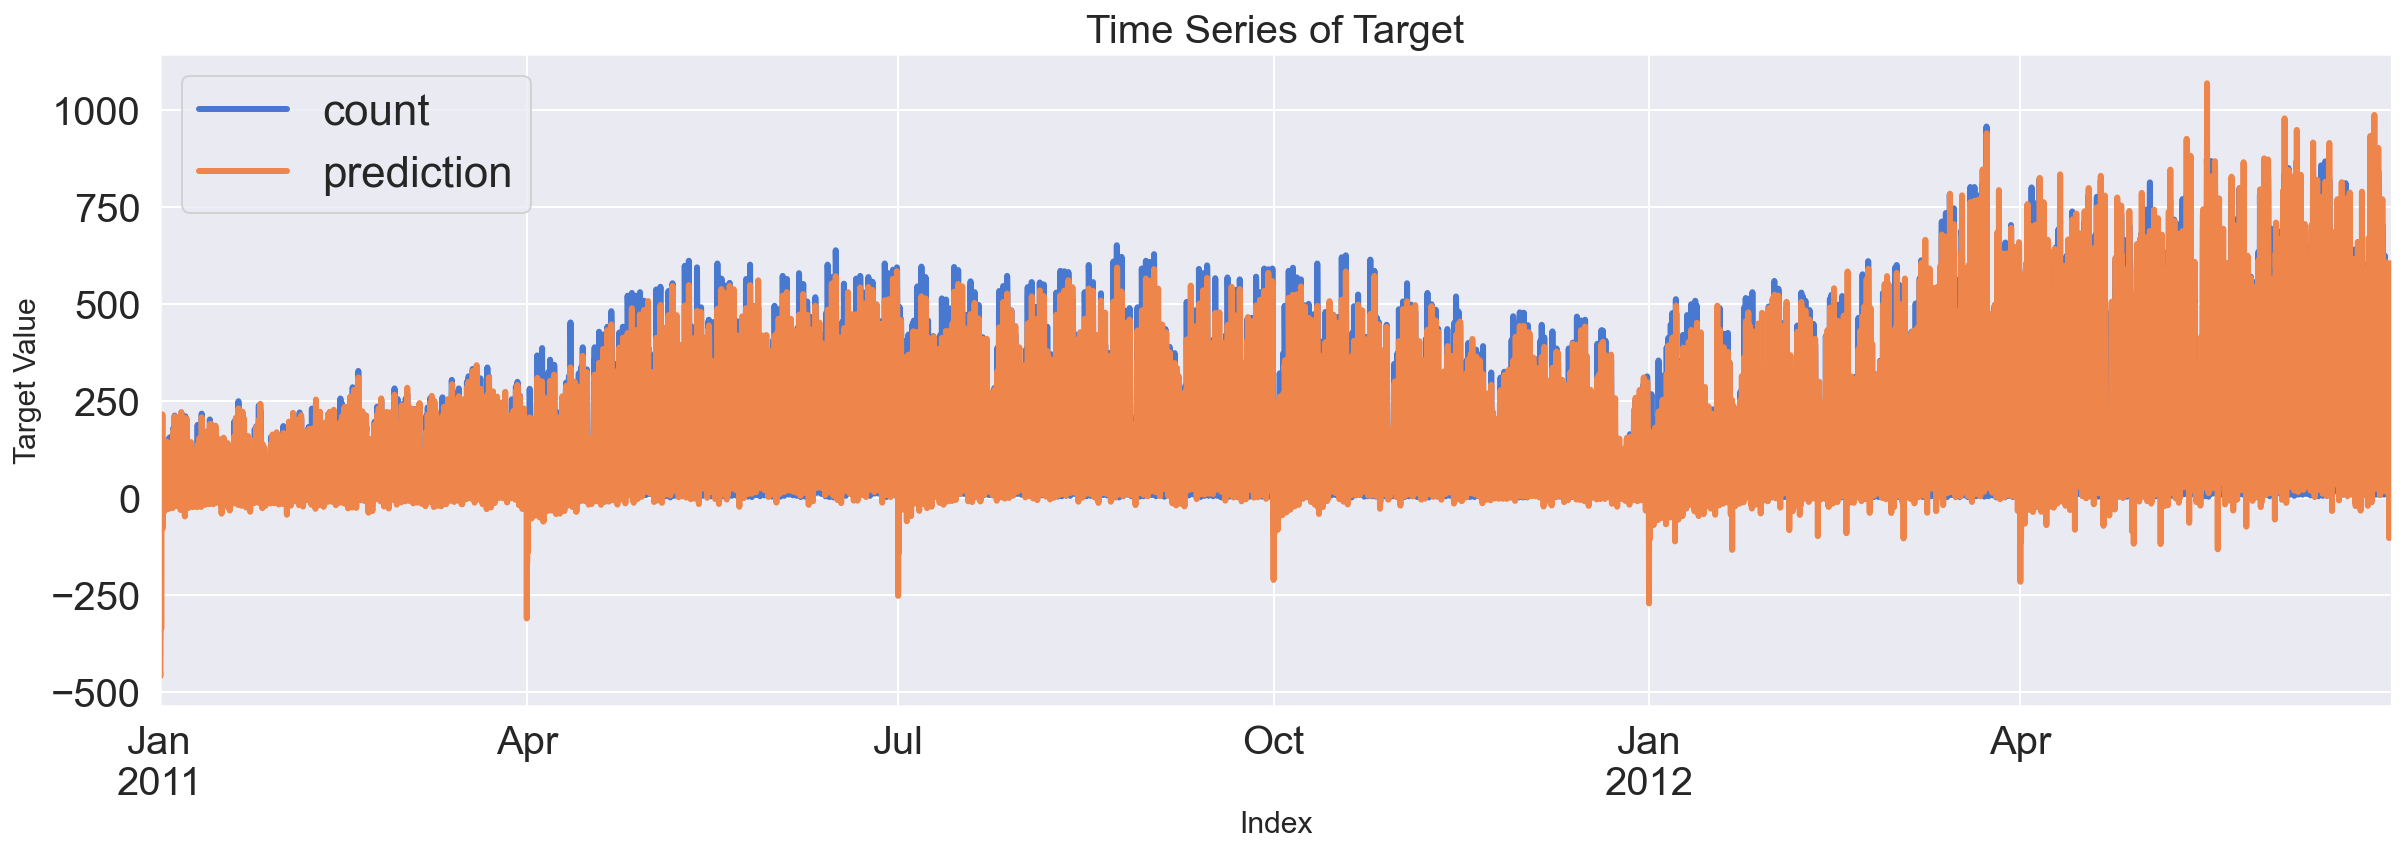

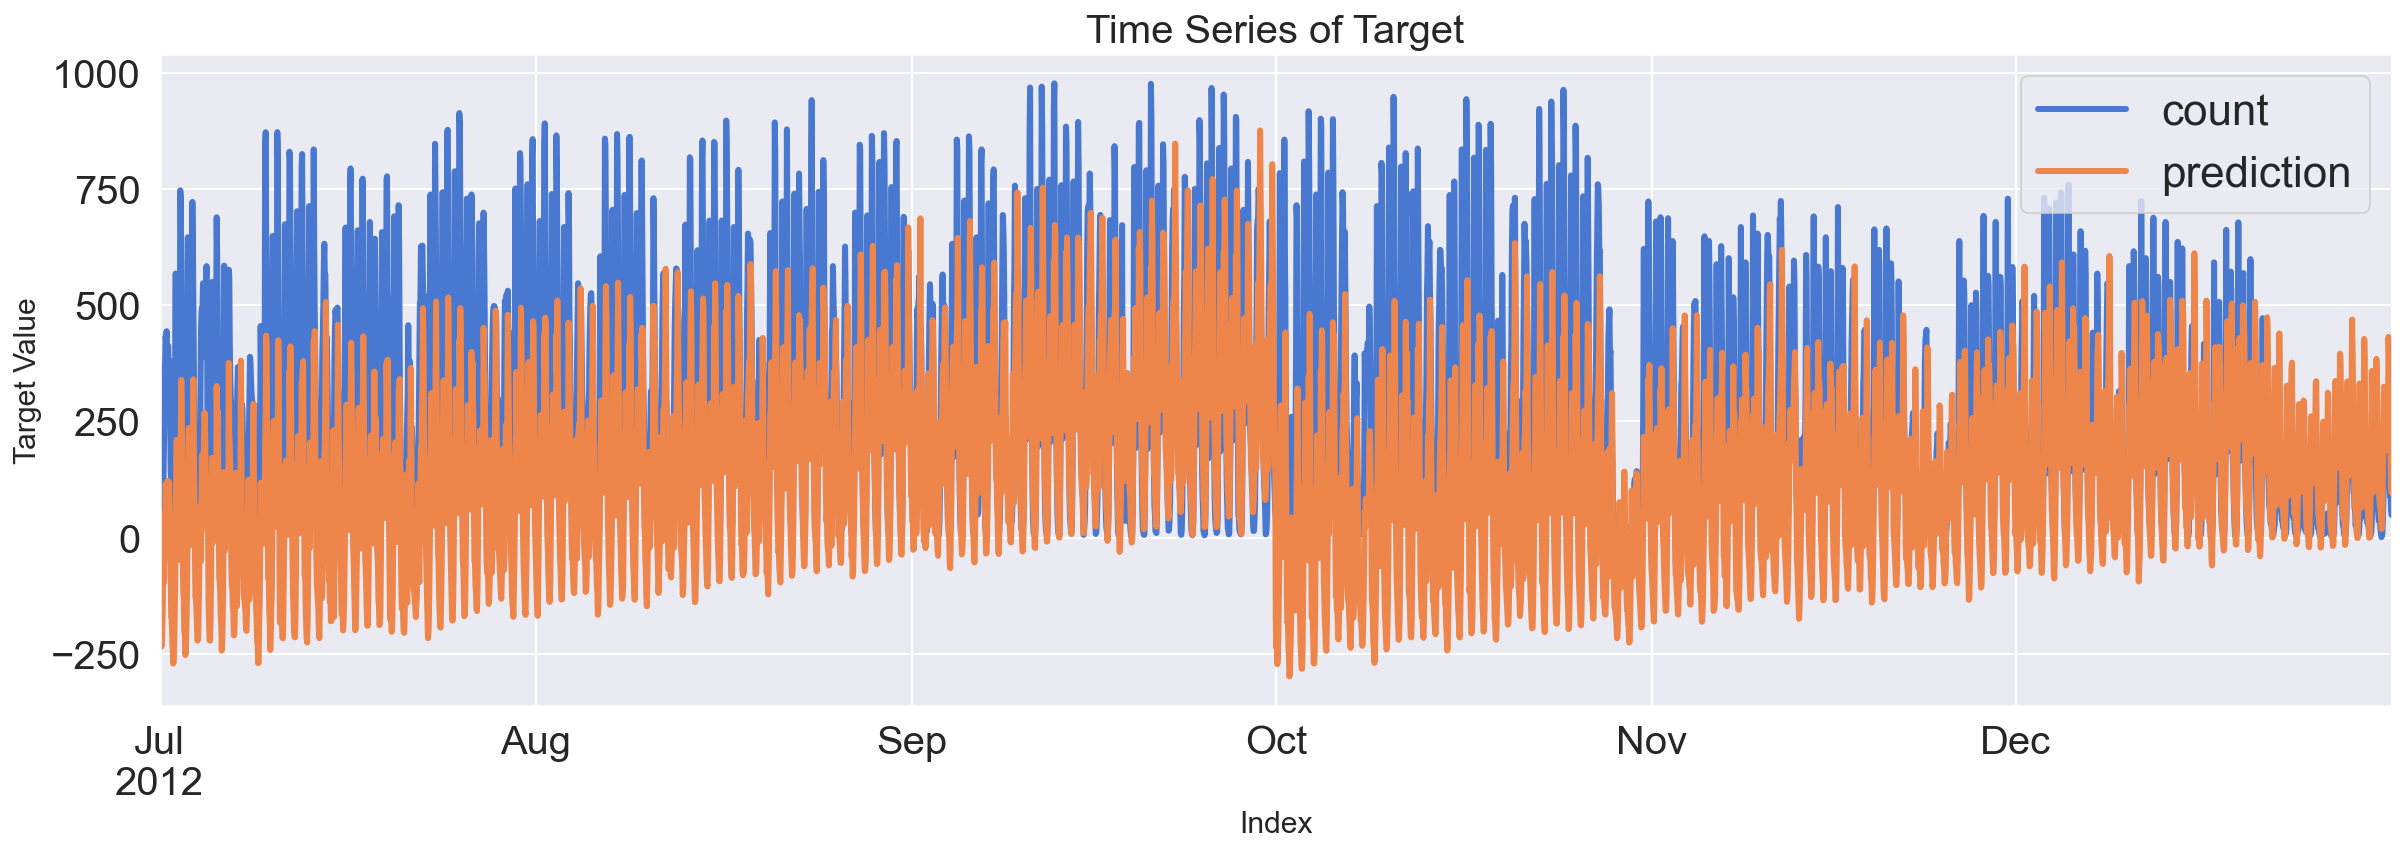

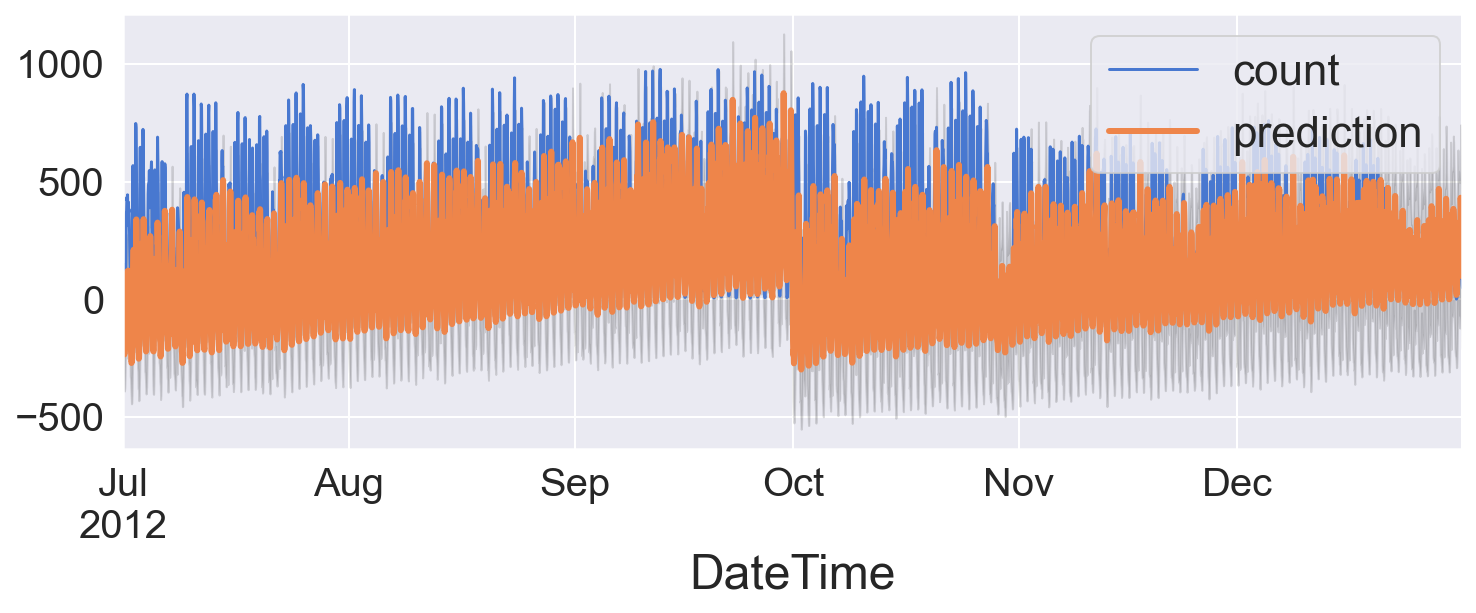

In [7]:
# 검증
Score_ts_sarimax, Resid_tr_ts_sarimax, Resid_te_ts_sarimax = evaluation_trte(Y_train_feR, pred_tr_ts_sarimax, 
                                                                             Y_test_feR, pred_te_ts_sarimax, graph_on=True)
display(Score_ts_sarimax)
ax = pd.DataFrame(Y_test_feR).plot(figsize=(12,4))
pd.DataFrame(pred_te_ts_sarimax, index=Y_test_feR.index, columns=['prediction']).plot(kind='line',
                                                                           xlim=(Y_test_feR.index.min(),Y_test_feR.index.max()),
                                                                           linewidth=3, fontsize=20, ax=ax)
ax.fill_between(pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).index,
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,0],
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,1], color='k', alpha=0.15)
plt.show()



### 잔차진단

In [9]:
Resid_tr_ts_sarimax

,Error
DateTime,
2011-01-01 00:00:00,426.99
2011-01-01 01:00:00,460.93
2011-01-01 02:00:00,474.02
2011-01-01 03:00:00,462.58
2011-01-01 04:00:00,452.42
...,...
2012-06-30 19:00:00,44.97
2012-06-30 20:00:00,-31.16
2012-06-30 21:00:00,-89.48


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

ADF:추세가 어느정도 제거되어 귀무가설(비정상)을 기각합니다.
KPSS:계절성이 어느정도 제거되어 귀무가설(정상) 기각 못합니다.


,Stationarity_adf,Stationarity_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-10.05,0.18,0.87,36.38,313.78,"1,336.54","3,075.17",2.45
p-value,0.00,0.10,0.00,0.00,0.00,0.00,0.00,0.00
Used Lag,41.00,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,086.00",nan,nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"138,495.97",nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,0.35,nan,nan,nan,nan,nan,NaN
Alternative,nan,nan,nan,nan,nan,nan,nan,two-sided


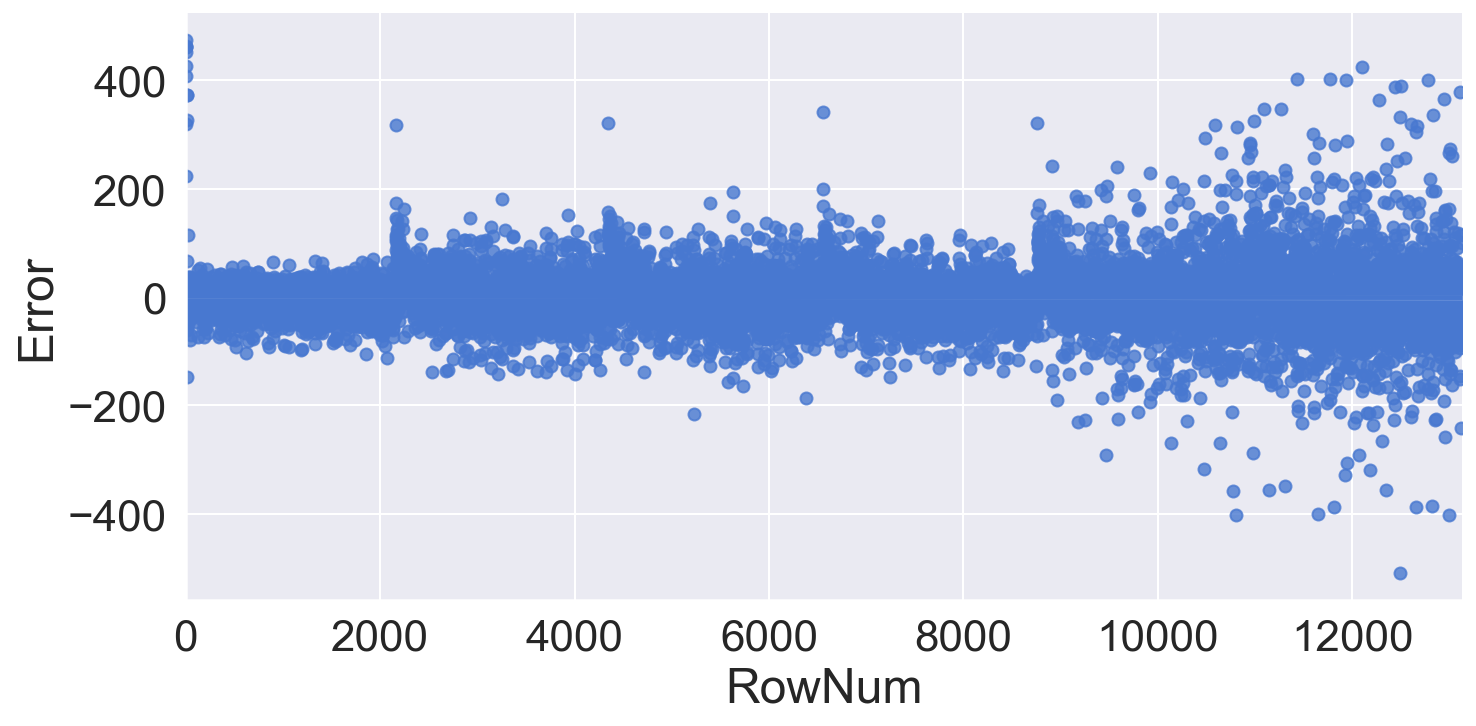

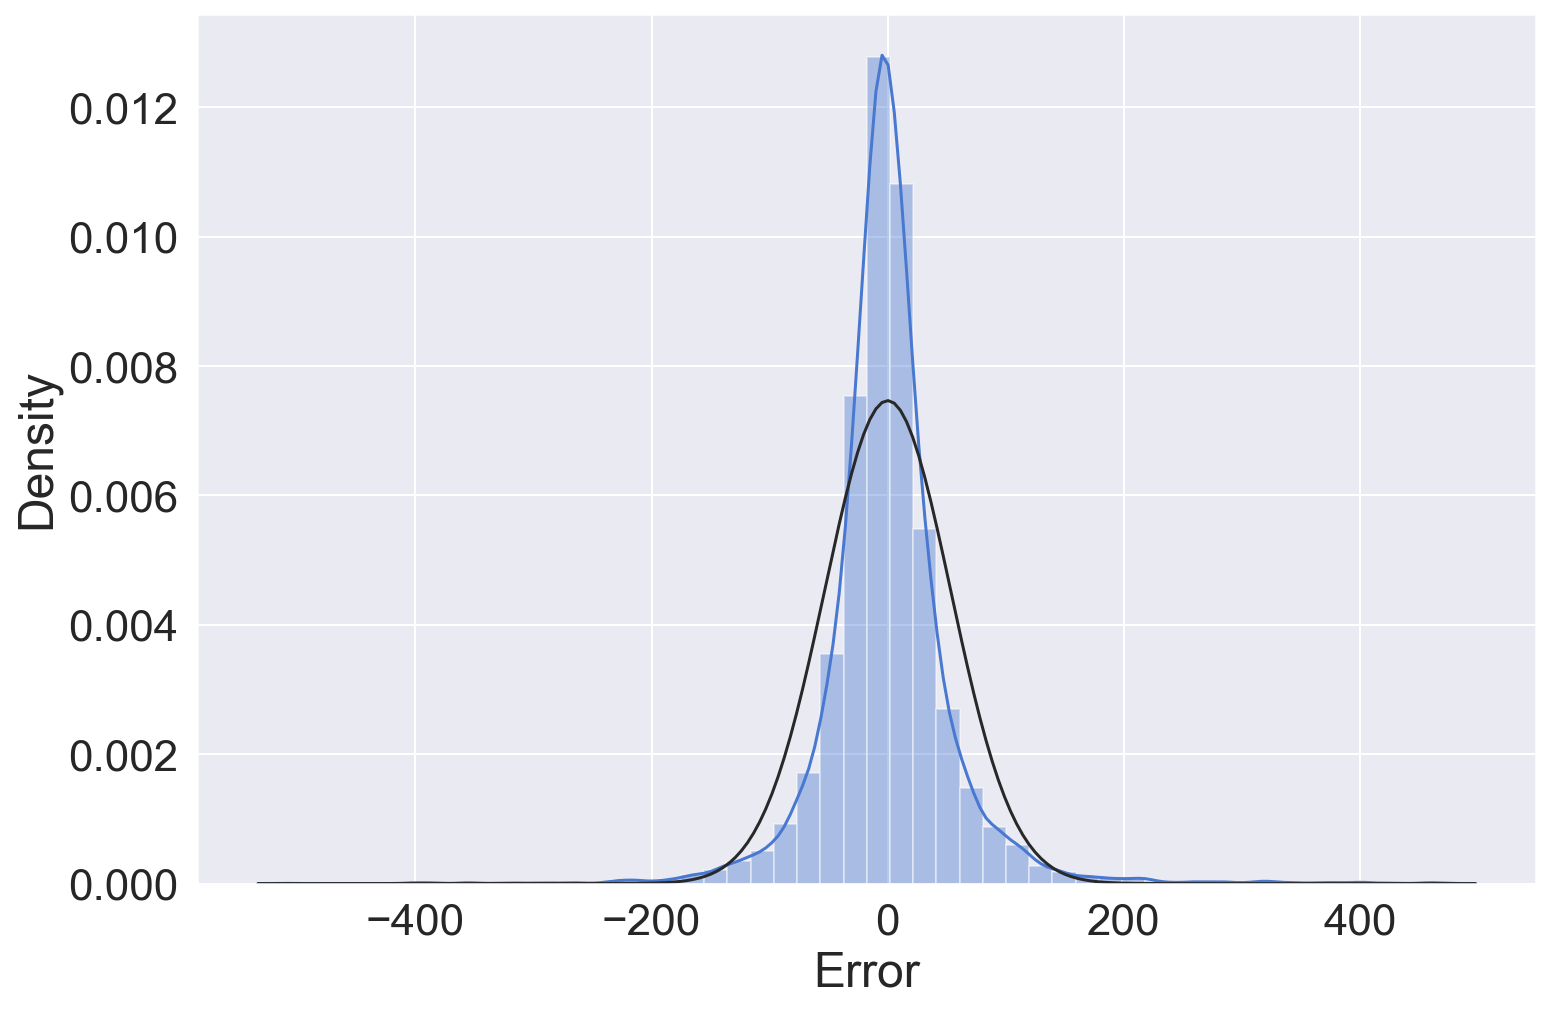

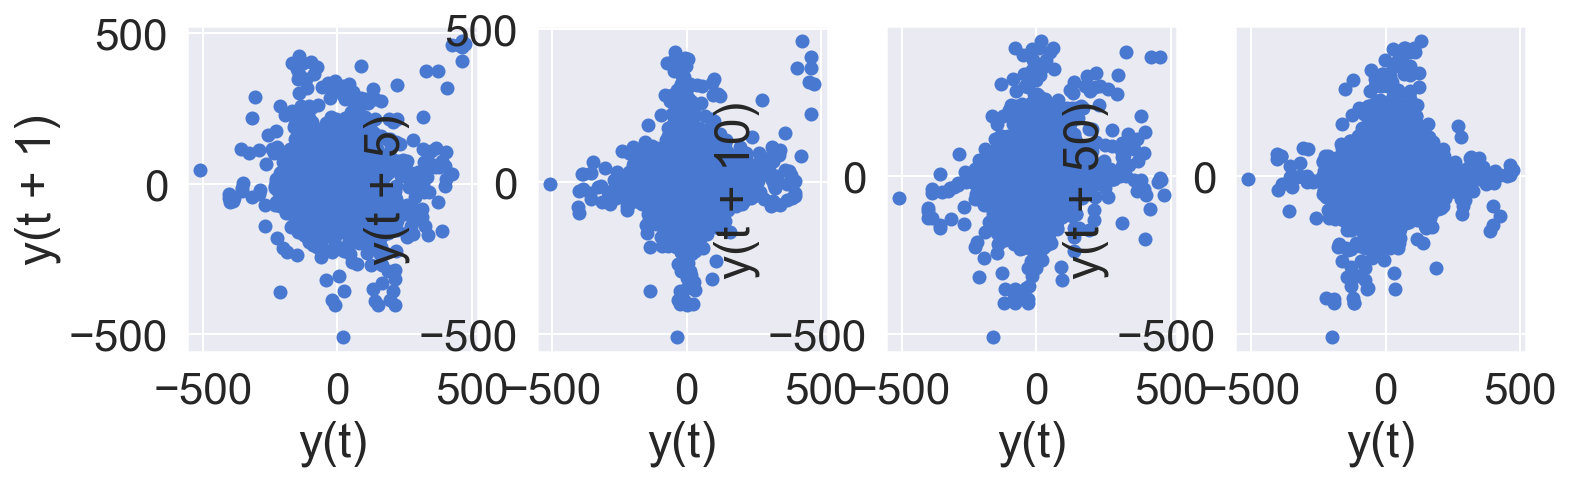

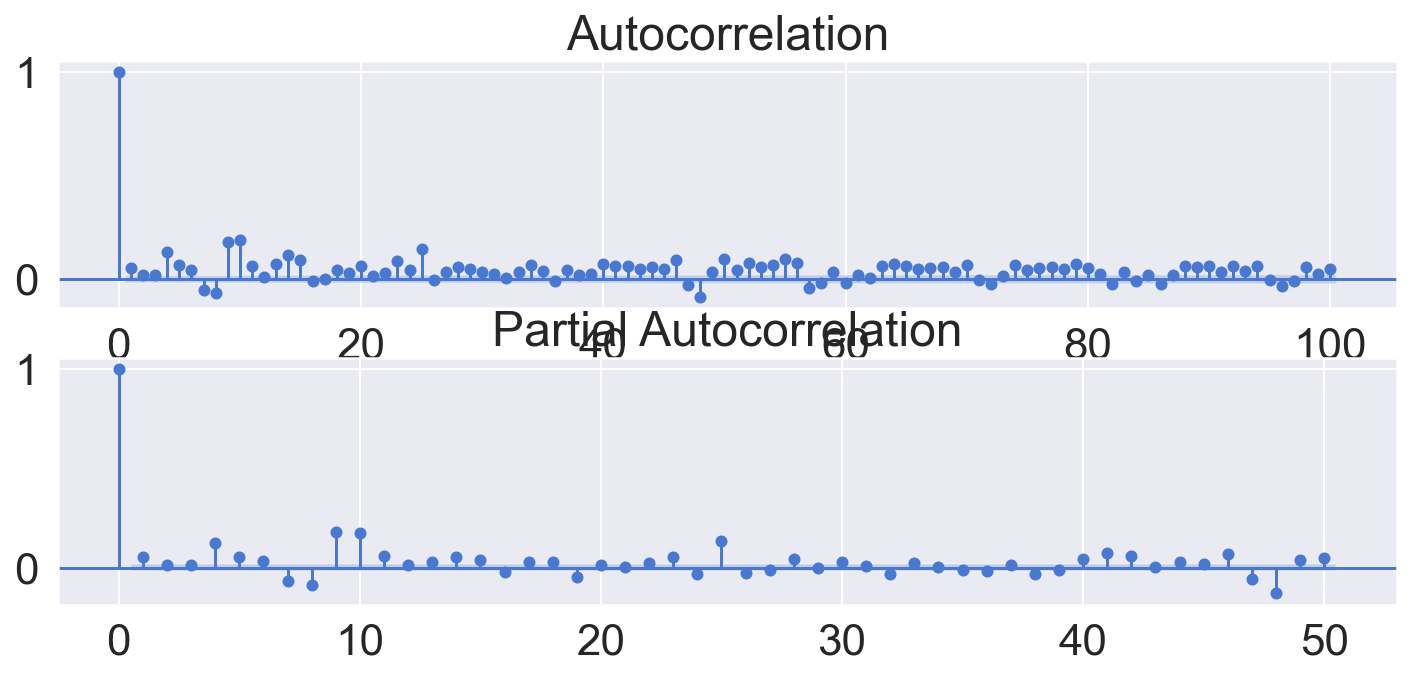

In [11]:
# 잔차진단
error_analysis(Resid_tr_ts_sarimax, ['Error'], Y_train_feR, graph_on=True)

## 코드 요약 : auto-arima (좀만 복잡해도 메모리에러)

### wine데이터로 잠깐 해보기

In [3]:
# Data Loading and Split
data = pm.datasets.load_wineind()
train, test = model_selection.train_test_split(data, train_size=150)

In [4]:
train

array([15136., 16733., 20016., 17708., 18019., 19227., 22893., 23739.,
       21133., 22591., 26786., 29740., 15028., 17977., 20008., 21354.,
       19498., 22125., 25817., 28779., 20960., 22254., 27392., 29945.,
       16933., 17892., 20533., 23569., 22417., 22084., 26580., 27454.,
       24081., 23451., 28991., 31386., 16896., 20045., 23471., 21747.,
       25621., 23859., 25500., 30998., 24475., 23145., 29701., 34365.,
       17556., 22077., 25702., 22214., 26886., 23191., 27831., 35406.,
       23195., 25110., 30009., 36242., 18450., 21845., 26488., 22394.,
       28057., 25451., 24872., 33424., 24052., 28449., 33533., 37351.,
       19969., 21701., 26249., 24493., 24603., 26485., 30723., 34569.,
       26689., 26157., 32064., 38870., 21337., 19419., 23166., 28286.,
       24570., 24001., 33151., 24878., 26804., 28967., 33311., 40226.,
       20504., 23060., 23562., 27562., 23940., 24584., 34303., 25517.,
       23494., 29095., 32903., 34379., 16991., 21109., 23740., 25552.,
      

In [2]:
autoarima = pm.auto_arima(train,  
                          stationary=False,
                          with_intercept=True,
                          start_p=0, d=None, start_q=0,
                          max_p=5, max_d=2, max_q=5,
                          seasonal=True, m=12,
                          start_P=0, D=None, start_Q=0,
                          max_P=5, max_D=2, max_Q=5,
                          max_order=100, maxiter=10,
                          information_criterion='bic',
                          trace=True, suppress_warnings=True)
display(autoarima.summary())

# fit 하는 부분
pred_tr_ts_autoarima = autoarima.predict_in_sample()

# 결과 내는 부분
pred_tr_ts_autoarima = autoarima.predict(n_periods=len(train))
pred_tr_ts_autoarima = pd.Series(pred_tr_ts_autoarima, name='prediction')
pred_te_ts_autoarima = autoarima.predict(n_periods=len(test), 
                                         return_conf_int=True)[0]
pred_te_ts_autoarima = pd.Series(pred_te_ts_autoarima, name='prediction')
pred_te_ts_autoarima_ci = autoarima.predict(n_periods=len(test), 
                                            return_conf_int=True)[1]

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : BIC=3055.604, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : BIC=2966.989, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : BIC=2959.029, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[12]             : BIC=3050.616, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : BIC=3000.550, Time=0.03 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : BIC=2941.183, Time=0.15 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : BIC=2937.552, Time=0.12 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : BIC=2940.326, Time=0.26 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : BIC=2945.278, Time=0.33 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : BIC=2975.047, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : BIC=2934.510, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : BIC=3002.994, Time=0.07 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : BIC=2937.192, Time=0.29 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : BIC=2938.344, Time=0.17 sec
 ARIMA(1,1,1)(0,0,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  150
Model:             SARIMAX(2, 1, 1)x(1, 0, [], 12)   Log Likelihood               -1449.395
Date:                             Thu, 03 Jun 2021   AIC                           2908.791
Time:                                     20:43:17   BIC                           2923.811
Sample:                                          0   HQIC                          2914.893
                                             - 150                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1043      0.214      0.488      0.625      -0.314       0.523
ar.L2         -0.1799      0.275     -0.654      0.513      -0.719       0.359
ma.L1         -0.8769      0.056    -15.676      0.000      -0.986      -0.767
ar.S.L12       0.7085      0.100      7.096      0.000       0.513       0.904
sigma2      2.844e+07   2.37e-09    1.2e+16      0.000    2.84e+07    2.84e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               397.92
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             1.15
Prob(H) (two-sided):                  0.05   Kurtosis:                        10.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.09e+31. Standard errors may be unstable.
"""

,MAE,MSE,MAPE
Train,"5,130.05","38,229,950.66",22.67
Test,"2,399.09","8,799,594.37",10.49


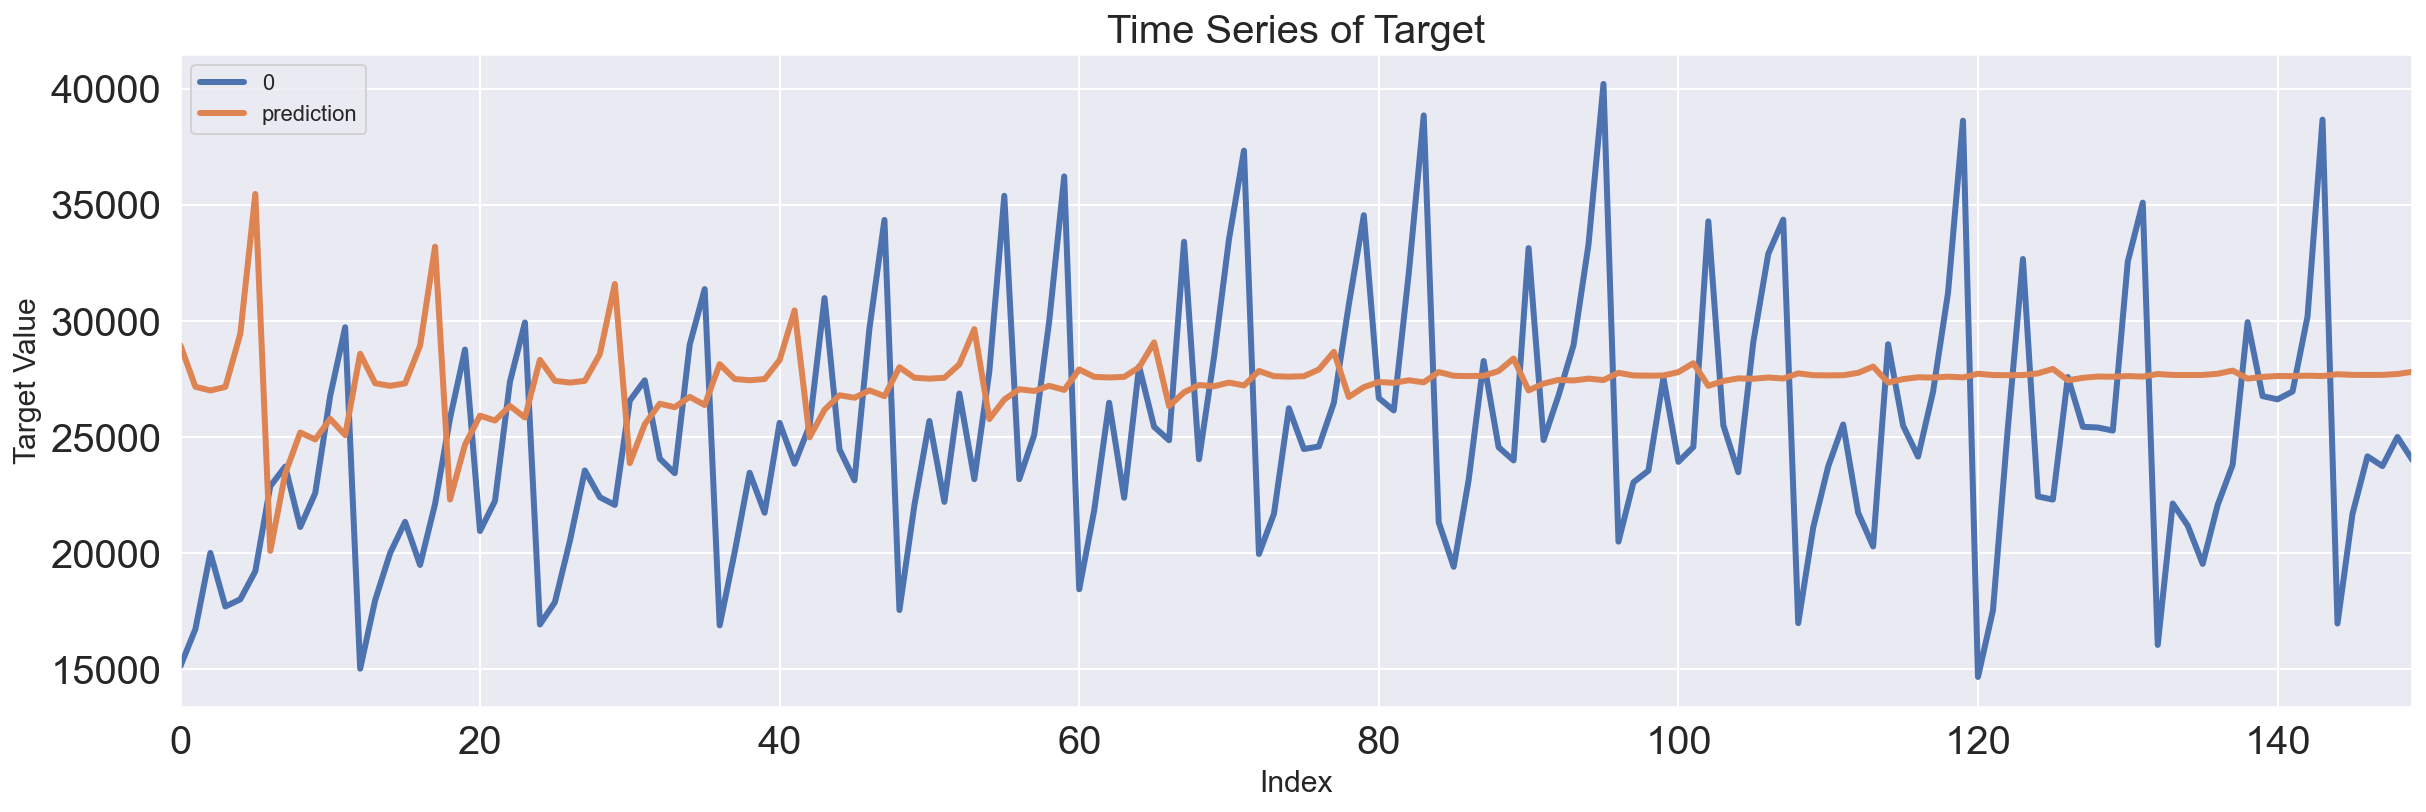

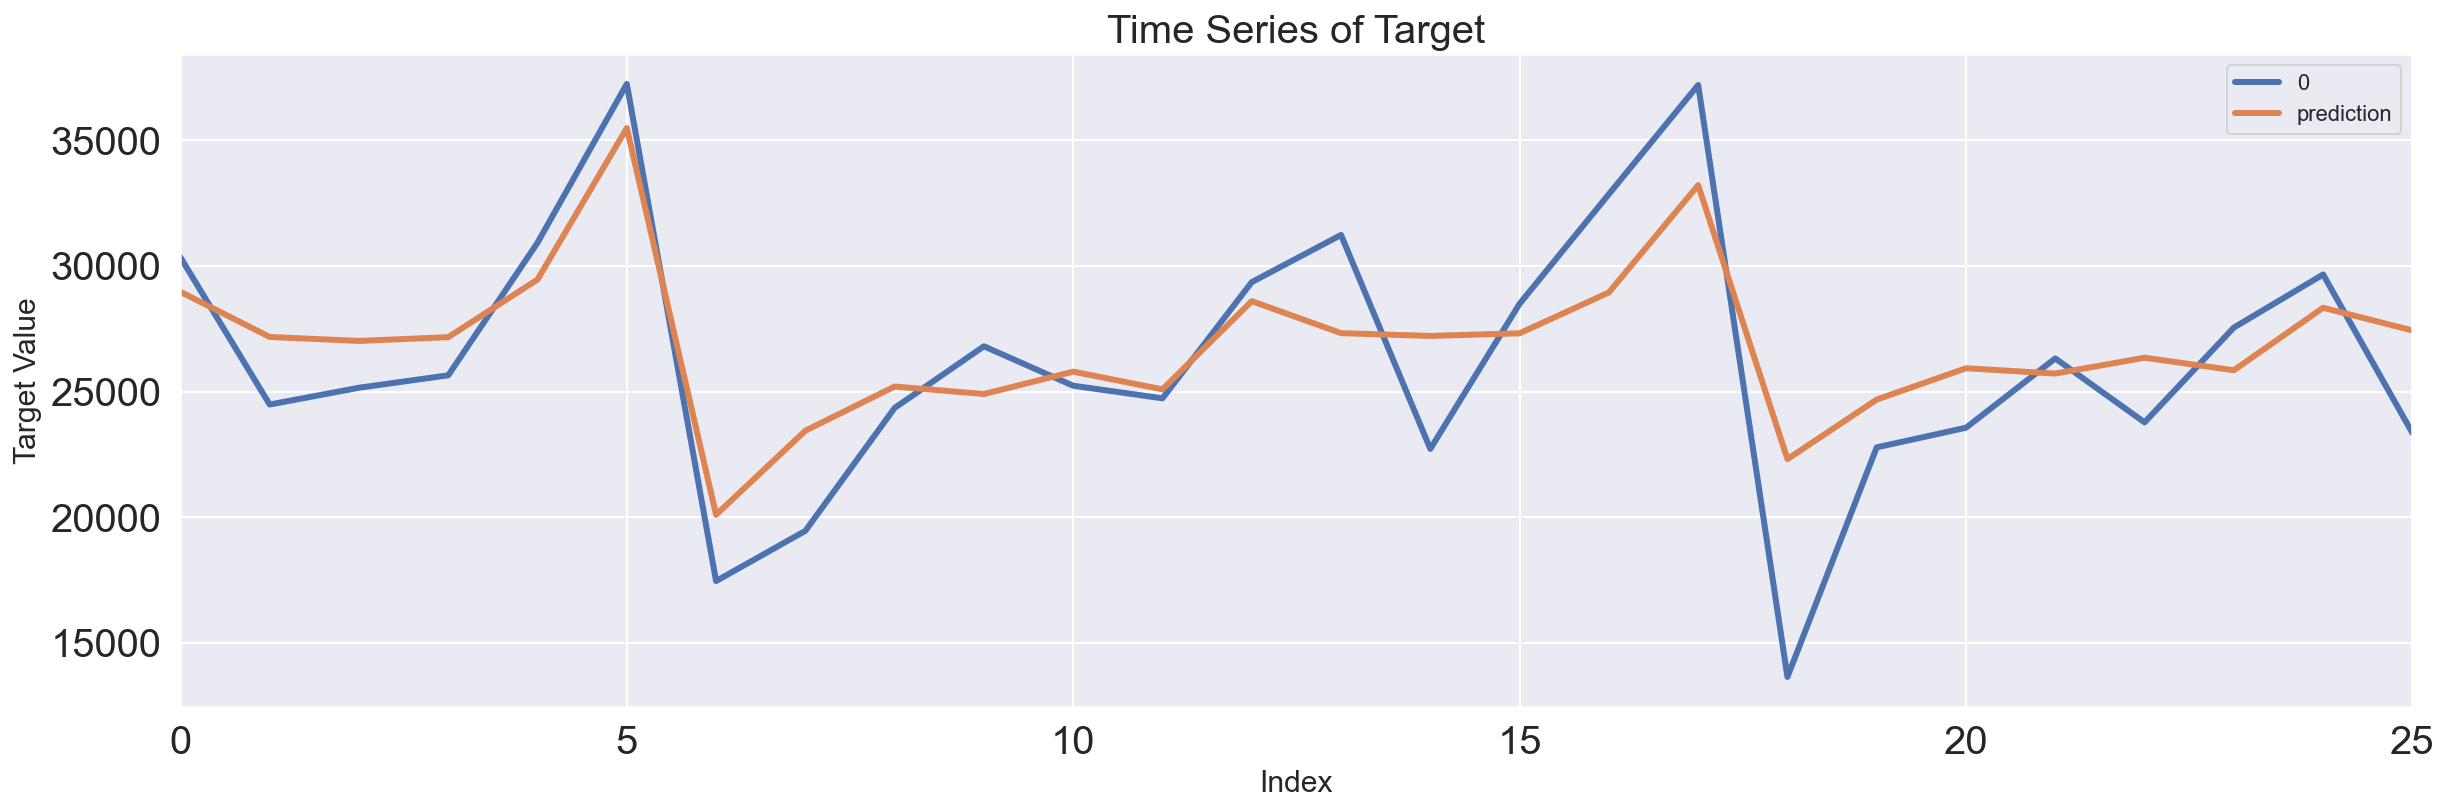

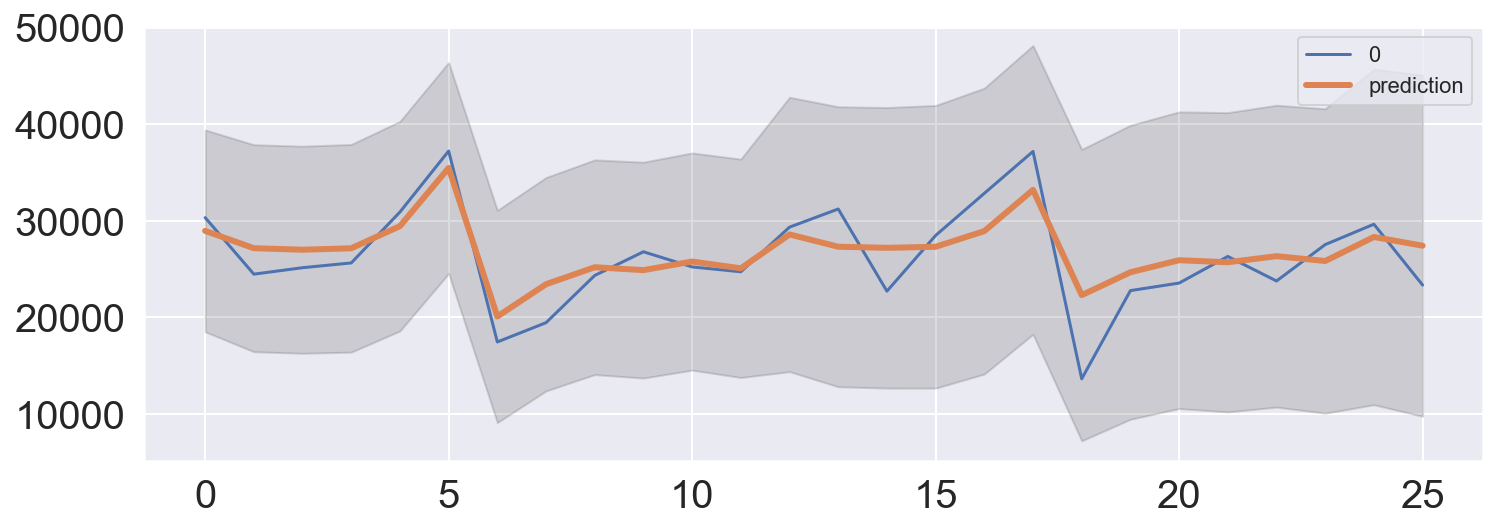

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

ADF:추세가 어느정도 남아있어 귀무가설(비정상) 기각 못합니다.
KPSS:계절성이 어느정도 남아있어 귀무가설(정상)을 기각합니다.


,Stationarity_adf,Stationarity_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-2.30,0.46,0.99,5.65,18.15,67.29,577.10,0.81
p-value,0.17,0.05,0.24,0.02,0.00,0.00,0.00,0.38
Used Lag,11.00,14.00,nan,nan,nan,nan,nan,NaN
Used Observations,138.00,nan,nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.48,nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"2,519.71",nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,0.35,nan,nan,nan,nan,nan,NaN
Alternative,nan,nan,nan,nan,nan,nan,nan,two-sided


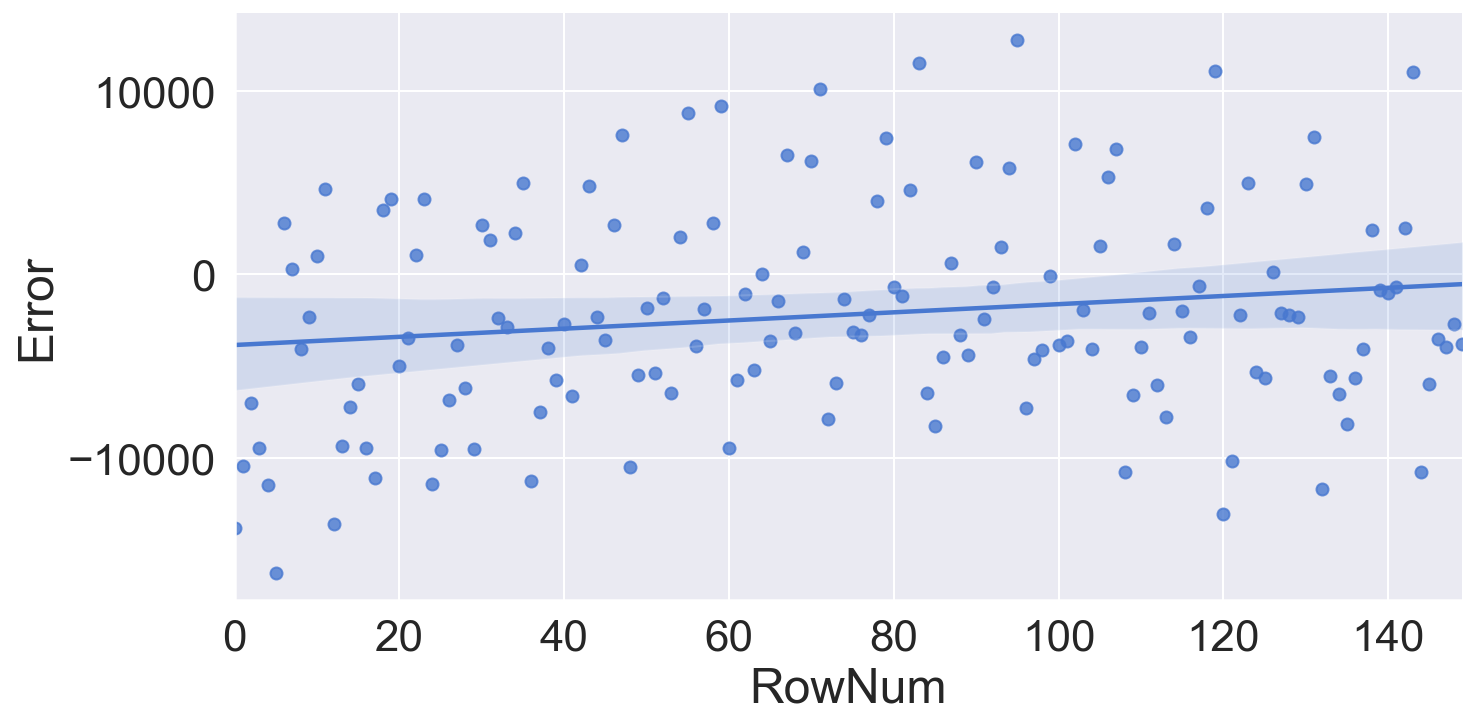

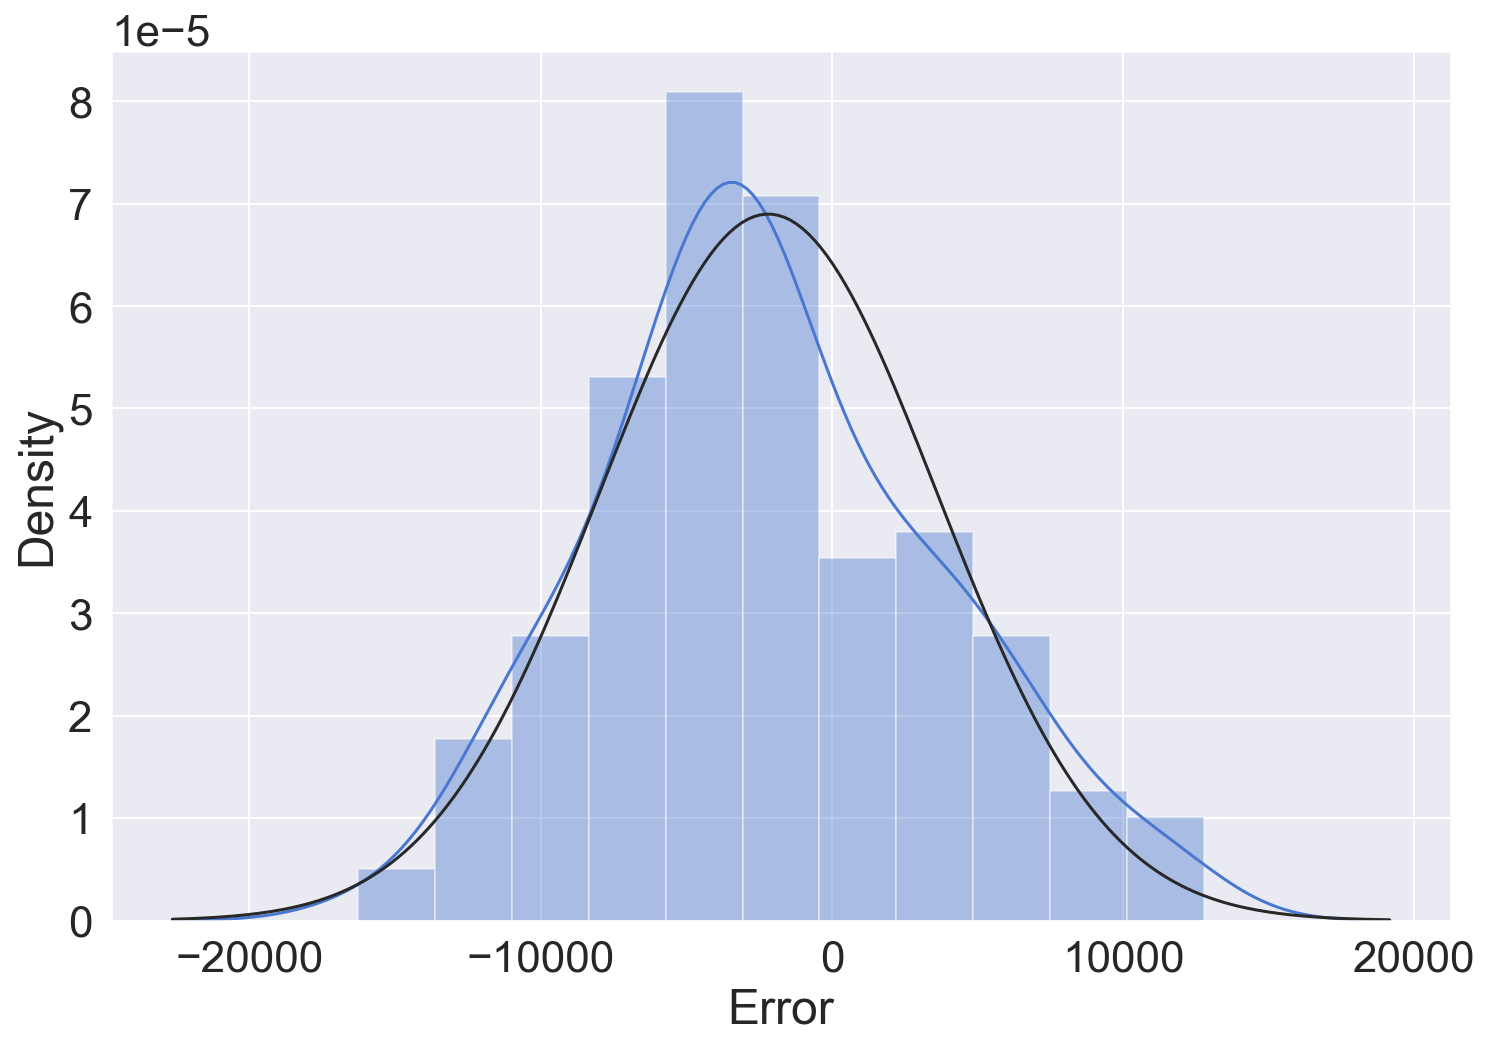

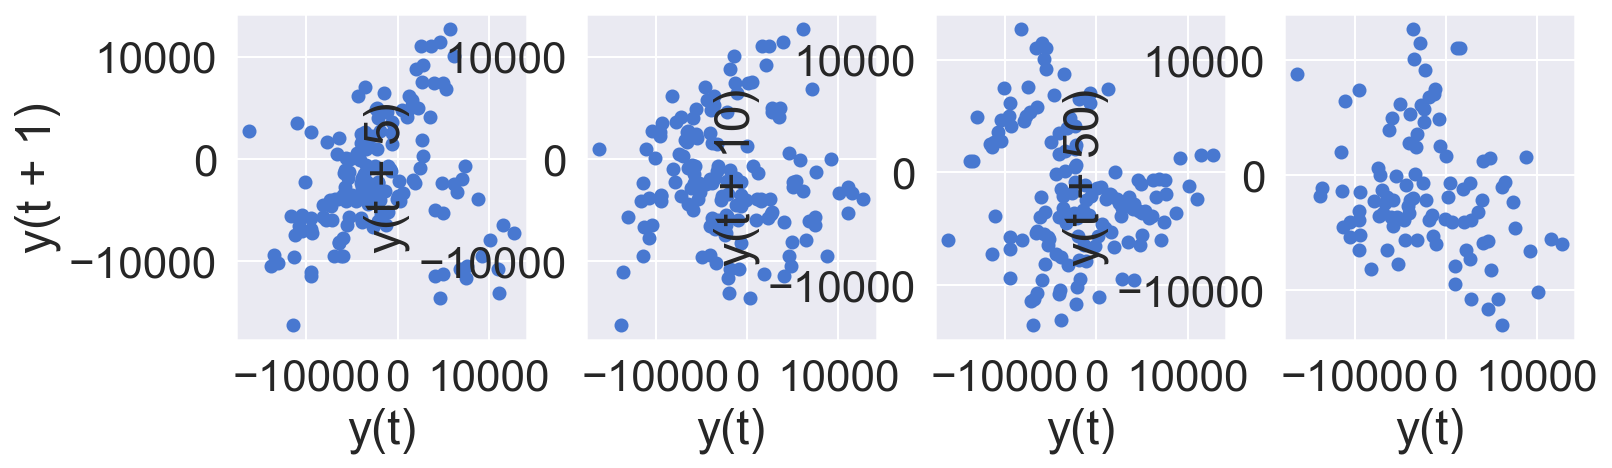

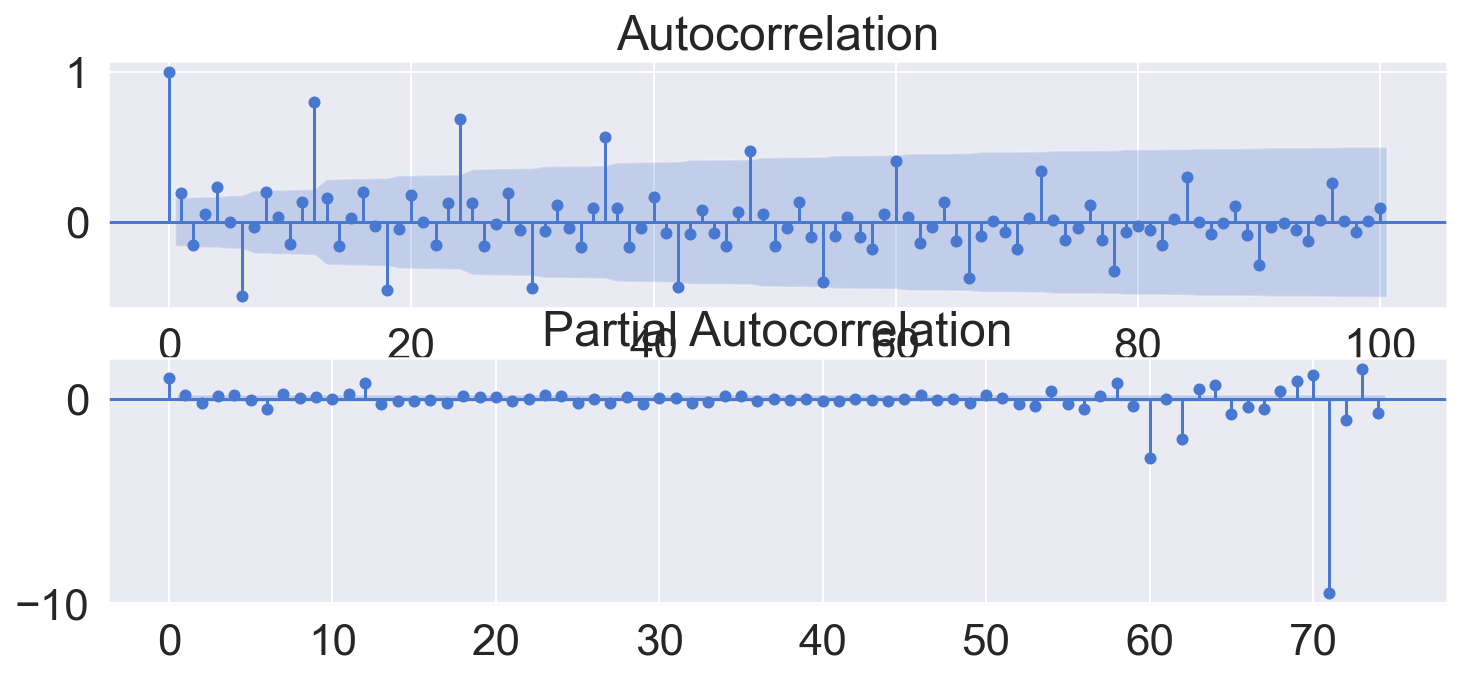

In [3]:
# 검증
Score_ts_autoarima, Resid_tr_ts_autoarima, Resid_te_ts_autoarima = evaluation_trte(pd.DataFrame(train), pred_tr_ts_autoarima, 
                                                                                   pd.DataFrame(test), pred_te_ts_autoarima, graph_on=True)
display(Score_ts_autoarima)
ax = pd.DataFrame(test).plot(figsize=(12,4))
pd.DataFrame(pred_te_ts_autoarima, columns=['prediction']).plot(kind='line',
                                                                linewidth=3, fontsize=20, ax=ax)
ax.fill_between(pd.DataFrame(pred_te_ts_autoarima_ci).index,
                pd.DataFrame(pred_te_ts_autoarima_ci).iloc[:,0],
                pd.DataFrame(pred_te_ts_autoarima_ci).iloc[:,1], color='k', alpha=0.15)
plt.show()

# 잔차진단
error_analysis(Resid_tr_ts_autoarima, ['Error'], pd.DataFrame(train), graph_on=True)

### 자전거 데이터로 해보기

- 메모리 에러 남

In [4]:
import pmdarima as pm

# Data Loading
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
location = './Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_fe = feature_engineering(raw_all)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_feR = feature_engineering_year_duplicated(raw_fe, target)
###############

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(raw_feR, Y_colname, X_colname, '2012-07-01')
### Reality ###
target = ['count_lag1', 'count_lag2']
X_test_feR = feature_engineering_lag_modified(Y_test_feR, X_test_feR, target)
###############
### Scaling ###
X_train_feRS, X_test_feRS = feature_engineering_scaling(preprocessing.Normalizer(), X_train_feR, X_test_feR)
###############
### Multicollinearity ###
print('Number_of_Total_X: ', len(X_train_feRS.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train_feRS, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_feRSM, X_test_feRSM = X_train_feRS[X_colname_vif].copy(), X_test_feRS[X_colname_vif].copy()
#########################

# 모델링
## Parameter Setting
trend_diff_order = 0
seasonal_diff_order, seasonal_order = 0, 24
## SARIMAX
fit_ts_autoarima = pm.auto_arima(Y_train_feR, 
                                 stationary=False,
                                 with_intercept=True,
                                 start_p=0, d=None, start_q=0,
                                 max_p=2, max_d=1, max_q=2,
                                 seasonal=True, m=24,
                                 start_P=0, D=None, start_Q=0,
                                 max_P=2, max_D=1, max_Q=2,
                                 max_order=30, maxiter=3,
                                 stepwise=False,
                                 exogenous=X_train_feRSM,
                                 information_criterion='aic',
                                 trace=True, suppress_warnings=True)
display(fit_ts_autoarima.summary())
pred_tr_ts_autoarima = fit_ts_autoarima.predict_in_sample(exogenous=X_train_feRSM)
pred_tr_ts_autoarima = fit_ts_autoarima.predict(n_periods=len(Y_train_feR), exogenous=X_train_feRSM)
pred_te_ts_autoarima = fit_ts_autoarima.predict(n_periods=len(Y_test_feR), 
                                                exogenous=X_test_feRSM, 
                                                return_conf_int=True)[0]
pred_te_ts_autoarima_ci = fit_ts_autoarima.predict(n_periods=len(Y_test_feR), 
                                                   exogenous=X_test_feRSM, 
                                                   return_conf_int=True)[1]

# 검증
Score_ts_autoarima, Resid_tr_ts_autoarima, Resid_te_ts_autoarima = evaluation_trte(Y_train_feR, pred_tr_ts_autoarima, 
                                                                                   Y_test_feR, pred_te_ts_autoarima, graph_on=True)
display(Score_ts_autoarima)
ax = pd.DataFrame(Y_test_feR).plot(figsize=(12,4))
pd.DataFrame(pred_te_ts_autoarima, 
             index=Y_test_feR.index, columns=['prediction']).plot(kind='line',
                                                                  xlim=(Y_test_feR.index.min(),Y_test_feR.index.max()),
                                                                  linewidth=3, fontsize=20, ax=ax)
ax.fill_between(pd.DataFrame(pred_te_ts_autoarima_ci, index=Y_test_feR.index).index,
                pd.DataFrame(pred_te_ts_autoarima_ci, index=Y_test_feR.index).iloc[:,0],
                pd.DataFrame(pred_te_ts_autoarima_ci, index=Y_test_feR.index).iloc[:,1], color='k', alpha=0.15)
plt.show()

# 잔차진단
error_analysis(Resid_tr_ts_autoarima, ['Error'], Y_train_feR, graph_on=True)

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
Number_of_Total_X:  24
Number_of_Selected_X:  12
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=144356.033, Time=1.10 sec
 ARIMA(0,1,0)(0,0,1)[24] intercept   : AIC=141777.341, Time=20.45 sec
 ARIMA(0,1,0)(0,0,2)[24] intercept   : AIC=141717.272, Time=89.98 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=141889.526, Time=30.21 sec
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=141749.812, Time=27.82 sec
 ARIMA(0,1,0)(1,0,2)[24] intercept   : AIC=141772.017, Time=104.51 sec


KeyboardInterrupt: 

# TS분석: Prophet
> **Paper:** https://peerj.com/preprints/3190.pdf  
> **Quick Start:** https://facebook.github.io/prophet/docs/quick_start.html  

> **기본가정:**
> - 자동화 된 기술은 상황에 맞게 튜닝하기 어렵고 경험적 지식을 반영하기 어려움
> - 분석가들은 도메인 지식만 풍부한 편이며 분석을 쉽게 다루지 못함
> - 비전문가가 경험적 특성을 반영할 수 있도록 필요한 부분을 자동화

## 전처리

In [2]:
# Data Loading
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
location = './Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_fe = feature_engineering(raw_all)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_feR = feature_engineering_year_duplicated(raw_fe, target)
###############

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(raw_feR, Y_colname, X_colname, '2012-07-01')
### Reality ###
target = ['count_lag1', 'count_lag2']
X_test_feR = feature_engineering_lag_modified(Y_test_feR, X_test_feR, target)
###############
### Scaling ###
X_train_feRS, X_test_feRS = feature_engineering_scaling(preprocessing.Normalizer(), X_train_feR, X_test_feR)
###############
### Multicollinearity ###
print('Number_of_Total_X: ', len(X_train_feRS.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train_feRS, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_feRSM, X_test_feRSM = X_train_feRS[X_colname_vif].copy(), X_test_feRS[X_colname_vif].copy()
#########################

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
Number_of_Total_X:  24
Number_of_Selected_X:  12


## Default

- changepoints : 회사의 이벤트 날짜. 과거든, 미래든,
    - 블랙프라이데이, 마케팅 시작 날짜, 공시날짜, 프로젝트 시작 날짜, 종료 날짜 등
    - 임상실험 결과 발표 날짜
- n_changepoints : 최대한 몇개 정도 있을 것인지 우리가 넣어주는 것
- changepoint_range : cp의 기존 데이터 수 대비 최대 비율. 0.8이라면, cp가 만약 1000개면, 최대로 많이 잡을 point를 800으로 잡음
- changepoint_prior_scale : changepoint 추정 민감도.. 높을수록 민감도
    - 숫자가 높아지면 cp를 ㅁ낳이 추정하려고 함. 작아지면 cp를 적게 추정하려고함

- Y를 trend, seasonality, residual로 분해
    - additive로 할지, multiplicativ로 할지
- seasonality_mode : additive or multiplicative
- seasonality_prior_scale : 계절성 추정 민감도. 높으면 계절성에 weight 높임
- daily/weekly/yearly_seasonality : 자동으로 해당 freq에 대한 계절성 있는지 확인

- holiday : DataFrame으로 넣어줌. 

- interval_width : 추세 예측 정확도 구간범위
    - 오리지널 Y 데이터 범위의 퍼센트
    - 예를들어 학습데이터의 Y 범위가 0에서 100이라면, 예측하는 Y의 범위는 50에서 100이라면 0.5

In [3]:
import timeit
start = timeit.default_timer()

from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet.plot import add_changepoints_to_plot

### Rearrange data

In [4]:
# Rearrange of Data
Y_train_feR_prophet = Y_train_feR.reset_index()
Y_train_feR_prophet.columns = ['ds', 'y']
YX_train_prophet = pd.concat([Y_train_feR_prophet, 
                              X_train_feRSM.reset_index().iloc[:,1:]], 
                              axis=1)
YX_train_prophet

,ds,y,count_diff,holiday,count_seasonal,Day,windspeed,Quater_ver2,Hour,weather,Quater_Dummy_2,DayofWeek,workingday,count_lag2
0,2011-01-01 00:00:00,16,0.01,0.00,-0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
1,2011-01-01 01:00:00,40,0.01,0.00,-0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
2,2011-01-01 02:00:00,32,-0.00,0.00,-0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
3,2011-01-01 03:00:00,13,-0.01,0.00,-0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02
4,2011-01-01 04:00:00,1,-0.01,0.00,-0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,2012-06-30 19:00:00,374,-0.06,0.00,0.06,0.01,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.17
13124,2012-06-30 20:00:00,292,-0.05,0.00,0.02,0.01,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.16
13125,2012-06-30 21:00:00,213,-0.01,0.00,-0.01,0.01,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.18
13126,2012-06-30 22:00:00,172,-0.06,0.00,-0.03,0.01,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.14


### 모델링

In [ ]:
Prophet()

In [ ]:
# Applying Prophet Model
fit_reg1_feRSM_prophet = Prophet(growth='linear',
                                 # Trend
                                 changepoints=None, # CP가 발생하는 시점들의 list ['2012-01-01']
                                 n_changepoints=25, # CP의 수
                                 changepoint_range=0.8, # CP의 기존 데이터 수 대비 최대 비율
                                 changepoint_prior_scale=0.05, # CP 추정 민감도로 높을수록 민감
                                 # Seasonality
                                 seasonality_mode='additive', # 계절성 모델: 'additive' or 'multiplicative'
                                 seasonality_prior_scale=10.0, # 계절성 추정 민감도로 높을수록 민감
                                 yearly_seasonality=True, # 연계절성
                                 weekly_seasonality='auto', # 주계절성
                                 daily_seasonality='auto', #일계절성
                                 # Holiday
                                 holidays=None, # 휴일 또는 이벤트 시점 dataframe
                                 holidays_prior_scale=10.0, # 휴일 추정 민감도로 높을수록 민감
                                 # Others
                                 interval_width=0.8, # 추세 예측 정확도 구간범위
                                 mcmc_samples=0 # 계절성 예측 정확도 제어
                                ) 
                                

fit_reg1_feRSM_prophet = fit_reg1_feRSM_prophet.fit(YX_train_prophet)

KeyError: 'metric_file'

Exception ignored in: 'stanfit4anon_model_f5236004a3fd5b8429270d00efcc0cf9_9045703871880297330._set_stanargs_from_dict'
Traceback (most recent call last):
  File "C:\Users\Hobin\anaconda3\lib\site-packages\pystan\model.py", line 550, in optimizing
    ret, sample = fit._call_sampler(stan_args)
KeyError: 'metric_file'


In [4]:


forecast = fit_reg1_feRSM_prophet.make_future_dataframe(freq='H', 
                                                        periods=Y_test_feR.shape[0])
pred_reg1_feRSM_prophet = fit_reg1_feRSM_prophet.predict(forecast)  # train / test 동시 출력
pred_tr_reg1_feRSM_prophet = np.ravel(pred_reg1_feRSM_prophet.loc[:Y_train_feR.shape[0]-1, ['yhat']])
pred_te_reg1_feRSM_prophet = np.ravel(pred_reg1_feRSM_prophet.loc[Y_train_feR.shape[0]:, ['yhat']])

# Result
display(pred_reg1_feRSM_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

fig = fit_reg1_feRSM_prophet.plot(pred_reg1_feRSM_prophet)
add_changepoints_to_plot(fig.gca(), fit_reg1_feRSM_prophet, pred_reg1_feRSM_prophet)
plt.xticks(rotation=90)
plt.show()

fig = fit_reg1_feRSM_prophet.plot_components(pred_reg1_feRSM_prophet)
ax = fig.get_axes()
for i in range(len(ax)):
    ax[i].tick_params(axis="x", labelsize=15, rotation=90)
plt.show()

## using plotly
# display(plot_plotly(fit_reg1_feRSM_prophet, pred_reg1_feRSM_prophet))
# display(plot_components_plotly(fit_reg1_feRSM_prophet, pred_reg1_feRSM_prophet))

# Evaluation
Score_reg1_feRSM_prophet, \
Resid_tr_reg1_feRSM_prophet, \
Resid_te_reg1_feRSM_prophet = evaluation_trte(Y_train_feR, 
                                              pred_tr_reg1_feRSM_prophet,
                                              Y_test_feR, 
                                              pred_te_reg1_feRSM_prophet, 
                                              graph_on=True)
display(Score_reg1_feRSM_prophet)

# Error Analysis
error_analysis(Resid_tr_reg1_feRSM_prophet, ['Error'], X_train_feRSM, graph_on=True)

stop = timeit.default_timer()
print('Time: ', stop - start)  

NameError: name 'Prophet' is not defined